# Batch Normalization - Text Data

## Giới thiệu

Batch Normalization cho dữ liệu text thường áp dụng trên sequence data với shape (batch, sequence_length, features) hoặc (batch, features, sequence_length).

Batch Normalization sẽ normalize theo:
- Mean và variance được tính trên batch dimension và sequence dimension
- Chỉ giữ lại feature dimension

## Công thức

```
mean = mean(x, dim=(0, 1))  # Tính mean theo batch và sequence dims
var = var(x, dim=(0, 1))    # Tính variance theo batch và sequence dims
x_norm = (x - mean) / sqrt(var + eps)
output = gamma * x_norm + beta
```

Trong đó:
- gamma: learnable scale parameter (một cho mỗi feature)
- beta: learnable shift parameter (một cho mỗi feature)
- eps: small constant để tránh chia cho 0


In [11]:
import numpy as np
import matplotlib.pyplot as plt

class BatchNorm1D:
    """
    Batch Normalization cho 1D text/sequence data (3D tensor: batch, sequence_length, features)
    """
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        
        # Learnable parameters
        self.gamma = np.ones(num_features)  # Scale
        self.beta = np.zeros(num_features)  # Shift
        
        # Running statistics (for inference)
        self.running_mean = np.zeros(num_features)
        self.running_var = np.ones(num_features)
        
    def forward(self, x, training=True):
        """
        x shape: (batch, sequence_length, features)
        """
        if training:
            # Tính mean và var theo batch và sequence dimensions
            # Keep dims: features
            mean = np.mean(x, axis=(0, 1), keepdims=True)
            var = np.var(x, axis=(0, 1), keepdims=True)
            
            # Update running statistics
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * np.squeeze(mean)
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * np.squeeze(var)
        else:
            # Sử dụng running statistics trong inference
            mean = self.running_mean.reshape(1, 1, -1)
            var = self.running_var.reshape(1, 1, -1)
        
        # Normalize
        x_norm = (x - mean) / np.sqrt(var + self.eps)
        
        # Scale and shift
        gamma = self.gamma.reshape(1, 1, -1)
        beta = self.beta.reshape(1, 1, -1)
        output = gamma * x_norm + beta
        
        return output




## Ví dụ 1: 1 Sample, 1 Feature

Shape: (1, 5, 1) - 1 batch, sequence length 5, 1 feature


Input shape: (1, 5, 1)
Input data:
[ 9.96714153  3.61735699 11.47688538 20.23029856  2.65846625]

Input mean: 9.5900
Input std: 6.3346

Output shape: (1, 5, 1)
Output data:
[ 0.05953185 -0.9428617   0.29786395  1.67970058 -1.09423469]

Output mean: -0.0000
Output std: 1.0000


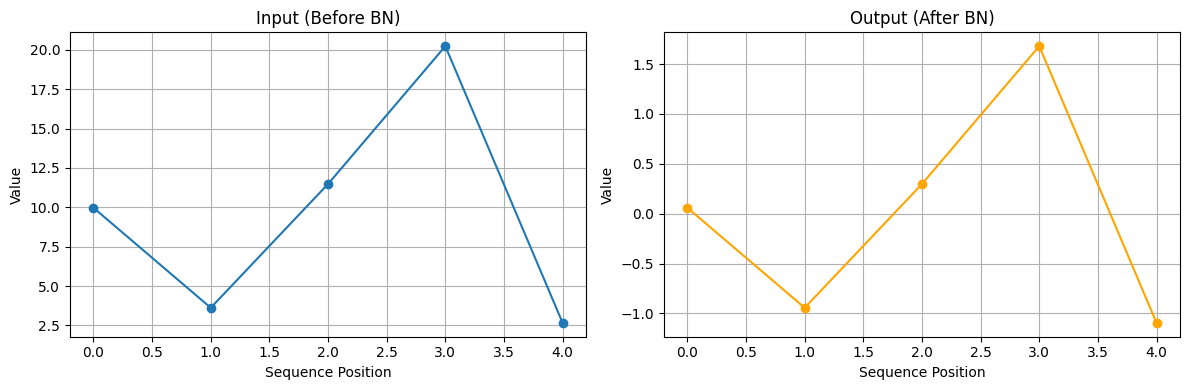

In [12]:
# Ví dụ 1: 1 Sample, 1 Feature
np.random.seed(42)
x1 = np.random.randn(1, 5, 1) * 10 + 5  # 1 batch, seq_len=5, 1 feature
print(f"Input shape: {x1.shape}")
print(f"Input data:\n{x1[0, :, 0]}")
print(f"\nInput mean: {np.mean(x1):.4f}")
print(f"Input std: {np.std(x1):.4f}")

# Khởi tạo BatchNorm
bn1 = BatchNorm1D(num_features=1)

# Forward pass
output1 = bn1.forward(x1, training=True)
print(f"\nOutput shape: {output1.shape}")
print(f"Output data:\n{output1[0, :, 0]}")
print(f"\nOutput mean: {np.mean(output1):.4f}")
print(f"Output std: {np.std(output1):.4f}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(x1[0, :, 0], marker='o')
axes[0].set_title('Input (Before BN)')
axes[0].set_xlabel('Sequence Position')
axes[0].set_ylabel('Value')
axes[0].grid(True)

axes[1].plot(output1[0, :, 0], marker='o', color='orange')
axes[1].set_title('Output (After BN)')
axes[1].set_xlabel('Sequence Position')
axes[1].set_ylabel('Value')
axes[1].grid(True)
plt.tight_layout()
plt.show()


## Ví dụ 2: 1 Sample, 2 Features

Shape: (1, 5, 2) - 1 batch, sequence length 5, 2 features


Input shape: (1, 5, 2)

Feature 0 mean: 9.0400, std: 7.2378
Feature 1 mean: 9.9212, std: 6.4280

Output shape: (1, 5, 2)

Feature 0 - Output mean: 0.0000, std: 1.0000
Feature 1 - Output mean: -0.0000, std: 1.0000


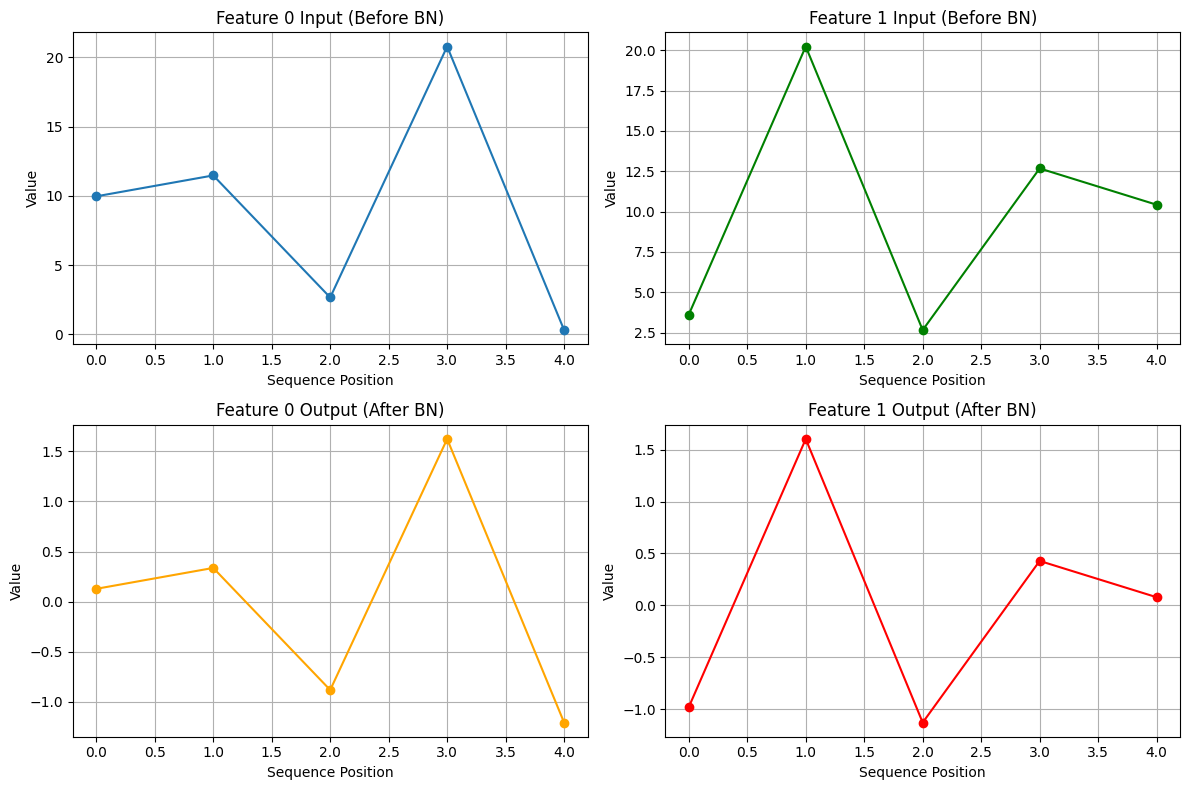

In [13]:
# Ví dụ 2: 1 Sample, 2 Features
np.random.seed(42)
x2 = np.random.randn(1, 5, 2) * 10 + 5  # 1 batch, seq_len=5, 2 features
print(f"Input shape: {x2.shape}")
print(f"\nFeature 0 mean: {np.mean(x2[0, :, 0]):.4f}, std: {np.std(x2[0, :, 0]):.4f}")
print(f"Feature 1 mean: {np.mean(x2[0, :, 1]):.4f}, std: {np.std(x2[0, :, 1]):.4f}")

# Khởi tạo BatchNorm với 2 features
bn2 = BatchNorm1D(num_features=2)

# Forward pass
output2 = bn2.forward(x2, training=True)
print(f"\nOutput shape: {output2.shape}")
print(f"\nFeature 0 - Output mean: {np.mean(output2[0, :, 0]):.4f}, std: {np.std(output2[0, :, 0]):.4f}")
print(f"Feature 1 - Output mean: {np.mean(output2[0, :, 1]):.4f}, std: {np.std(output2[0, :, 1]):.4f}")

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes[0, 0].plot(x2[0, :, 0], marker='o')
axes[0, 0].set_title('Feature 0 Input (Before BN)')
axes[0, 0].set_xlabel('Sequence Position')
axes[0, 0].set_ylabel('Value')
axes[0, 0].grid(True)

axes[0, 1].plot(x2[0, :, 1], marker='o', color='green')
axes[0, 1].set_title('Feature 1 Input (Before BN)')
axes[0, 1].set_xlabel('Sequence Position')
axes[0, 1].set_ylabel('Value')
axes[0, 1].grid(True)

axes[1, 0].plot(output2[0, :, 0], marker='o', color='orange')
axes[1, 0].set_title('Feature 0 Output (After BN)')
axes[1, 0].set_xlabel('Sequence Position')
axes[1, 0].set_ylabel('Value')
axes[1, 0].grid(True)

axes[1, 1].plot(output2[0, :, 1], marker='o', color='red')
axes[1, 1].set_title('Feature 1 Output (After BN)')
axes[1, 1].set_xlabel('Sequence Position')
axes[1, 1].set_ylabel('Value')
axes[1, 1].grid(True)
plt.tight_layout()
plt.show()


## Ví dụ 3: 2 Samples, 1 Feature

Shape: (2, 5, 1) - 2 batches, sequence length 5, 1 feature

Trong trường hợp này, BatchNorm sẽ tính mean và variance trên cả 2 samples trong batch.


Input shape: (2, 5, 1)

Sample 0 mean: 9.5900, std: 6.3346
Sample 1 mean: 9.3712, std: 7.3445
Overall mean (across batch): 9.4806, std: 6.8591

Output shape: (2, 5, 1)

Sample 0 - Output mean: 0.0160, std: 0.9235
Sample 1 - Output mean: -0.0160, std: 1.0708
Overall output mean: -0.0000, std: 1.0000


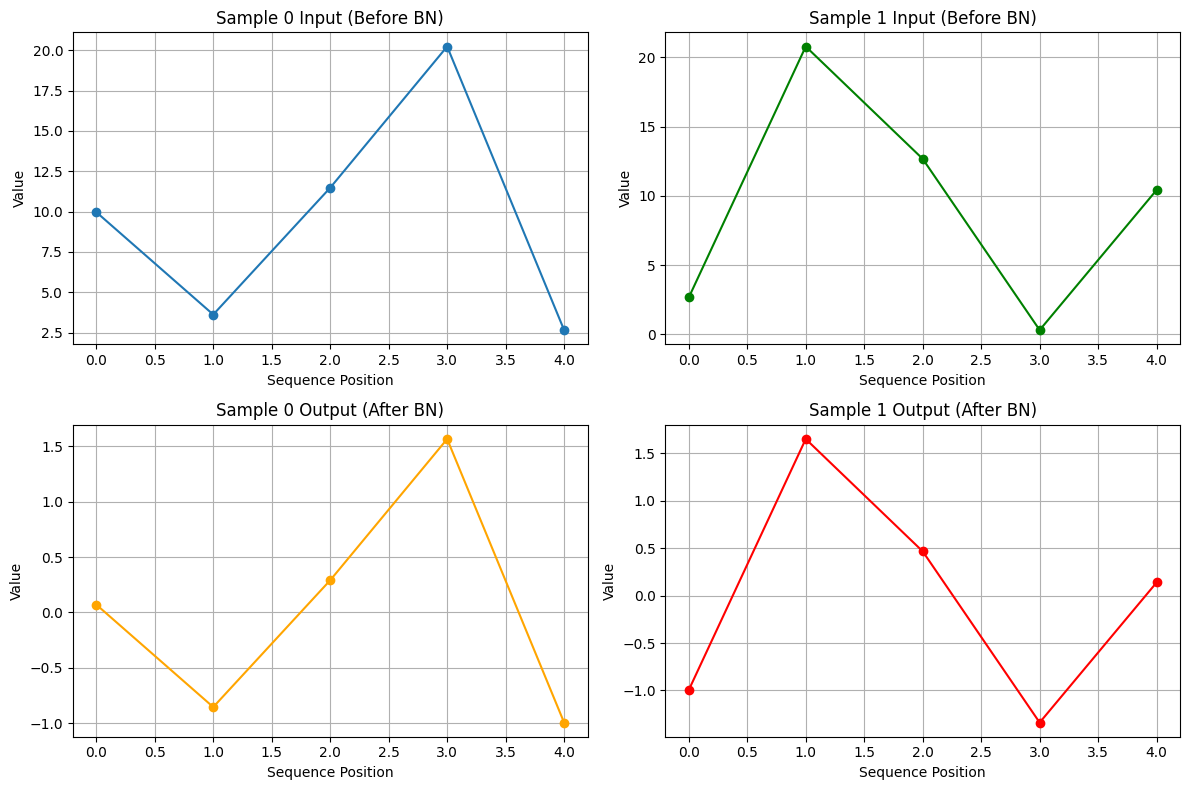

In [14]:
# Ví dụ 3: 2 Samples, 1 Feature
np.random.seed(42)
x3 = np.random.randn(2, 5, 1) * 10 + 5  # 2 batches, seq_len=5, 1 feature
print(f"Input shape: {x3.shape}")
print(f"\nSample 0 mean: {np.mean(x3[0]):.4f}, std: {np.std(x3[0]):.4f}")
print(f"Sample 1 mean: {np.mean(x3[1]):.4f}, std: {np.std(x3[1]):.4f}")
print(f"Overall mean (across batch): {np.mean(x3):.4f}, std: {np.std(x3):.4f}")

# Khởi tạo BatchNorm
bn3 = BatchNorm1D(num_features=1)

# Forward pass
output3 = bn3.forward(x3, training=True)
print(f"\nOutput shape: {output3.shape}")
print(f"\nSample 0 - Output mean: {np.mean(output3[0]):.4f}, std: {np.std(output3[0]):.4f}")
print(f"Sample 1 - Output mean: {np.mean(output3[1]):.4f}, std: {np.std(output3[1]):.4f}")
print(f"Overall output mean: {np.mean(output3):.4f}, std: {np.std(output3):.4f}")

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes[0, 0].plot(x3[0, :, 0], marker='o')
axes[0, 0].set_title('Sample 0 Input (Before BN)')
axes[0, 0].set_xlabel('Sequence Position')
axes[0, 0].set_ylabel('Value')
axes[0, 0].grid(True)

axes[0, 1].plot(x3[1, :, 0], marker='o', color='green')
axes[0, 1].set_title('Sample 1 Input (Before BN)')
axes[0, 1].set_xlabel('Sequence Position')
axes[0, 1].set_ylabel('Value')
axes[0, 1].grid(True)

axes[1, 0].plot(output3[0, :, 0], marker='o', color='orange')
axes[1, 0].set_title('Sample 0 Output (After BN)')
axes[1, 0].set_xlabel('Sequence Position')
axes[1, 0].set_ylabel('Value')
axes[1, 0].grid(True)

axes[1, 1].plot(output3[1, :, 0], marker='o', color='red')
axes[1, 1].set_title('Sample 1 Output (After BN)')
axes[1, 1].set_xlabel('Sequence Position')
axes[1, 1].set_ylabel('Value')
axes[1, 1].grid(True)
plt.tight_layout()
plt.show()


## Ví dụ 4: 2 Samples, 2 Features

Shape: (2, 5, 2) - 2 batches, sequence length 5, 2 features

Đây là trường hợp đầy đủ nhất với nhiều samples và nhiều features.


Input shape: (2, 5, 2)
Sample 0, Feature 0 - mean: 9.0400, std: 7.2378
Sample 0, Feature 1 - mean: 9.9212, std: 6.4280
Sample 1, Feature 0 - mean: -2.7345, std: 6.4929
Sample 1, Feature 1 - mean: -3.0787, std: 7.7766

Output shape: (2, 5, 2)
Sample 0, Feature 0 - Output mean: 0.6504, std: 0.7996
Sample 0, Feature 1 - Output mean: 0.6735, std: 0.6660
Sample 1, Feature 0 - Output mean: -0.6504, std: 0.7173
Sample 1, Feature 1 - Output mean: -0.6735, std: 0.8058


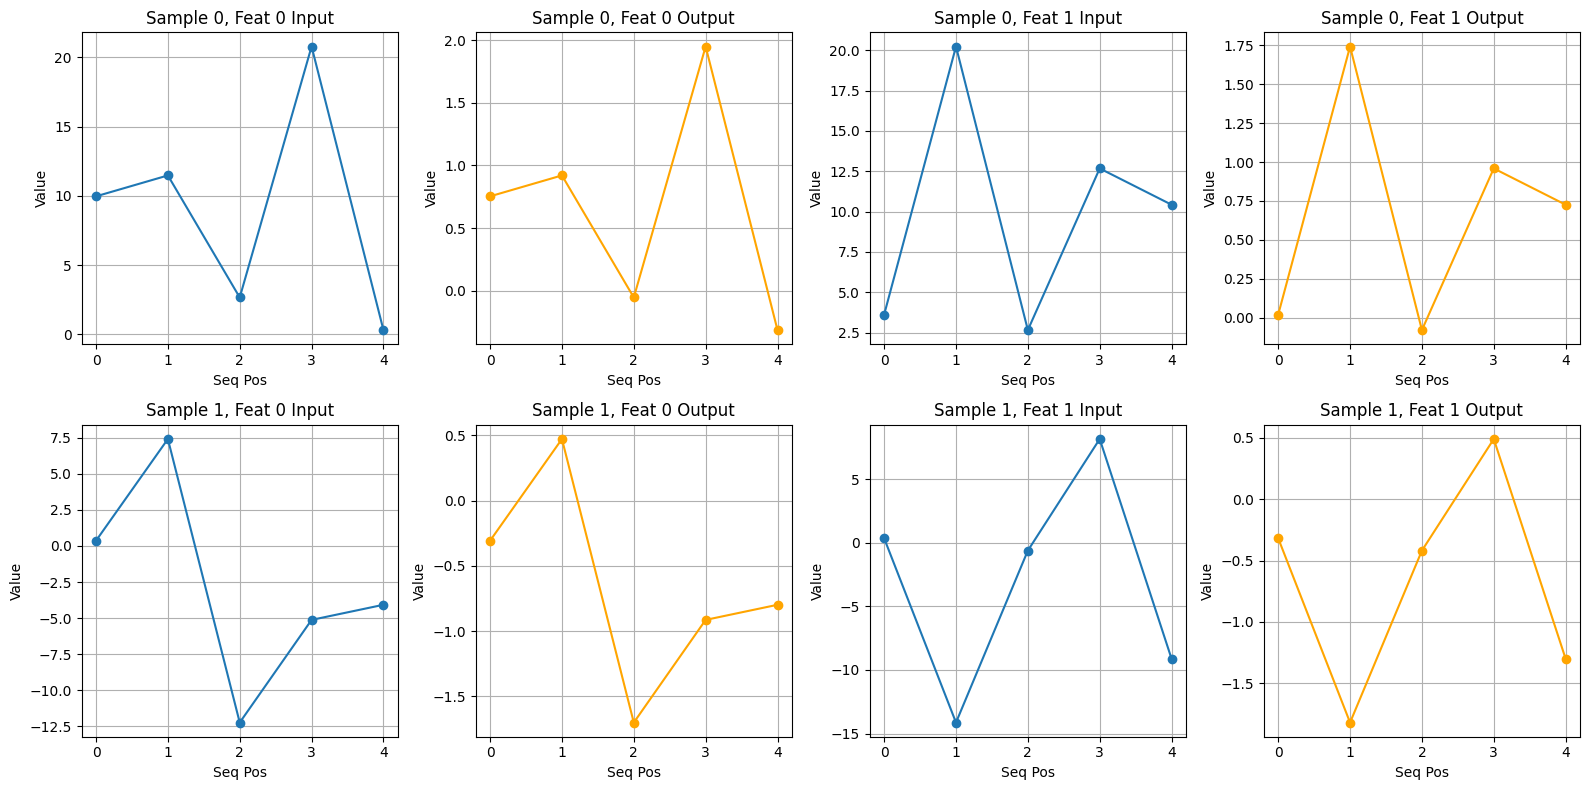

In [15]:
# Ví dụ 4: 2 Samples, 2 Features
np.random.seed(42)
x4 = np.random.randn(2, 5, 2) * 10 + 5  # 2 batches, seq_len=5, 2 features
print(f"Input shape: {x4.shape}")

for b in range(2):
    for f in range(2):
        print(f"Sample {b}, Feature {f} - mean: {np.mean(x4[b, :, f]):.4f}, std: {np.std(x4[b, :, f]):.4f}")

# Khởi tạo BatchNorm với 2 features
bn4 = BatchNorm1D(num_features=2)

# Forward pass
output4 = bn4.forward(x4, training=True)
print(f"\nOutput shape: {output4.shape}")

for b in range(2):
    for f in range(2):
        print(f"Sample {b}, Feature {f} - Output mean: {np.mean(output4[b, :, f]):.4f}, std: {np.std(output4[b, :, f]):.4f}")

# Visualize
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for b in range(2):
    for f in range(2):
        axes[b, f*2].plot(x4[b, :, f], marker='o')
        axes[b, f*2].set_title(f'Sample {b}, Feat {f} Input')
        axes[b, f*2].set_xlabel('Seq Pos')
        axes[b, f*2].set_ylabel('Value')
        axes[b, f*2].grid(True)
        
        axes[b, f*2+1].plot(output4[b, :, f], marker='o', color='orange')
        axes[b, f*2+1].set_title(f'Sample {b}, Feat {f} Output')
        axes[b, f*2+1].set_xlabel('Seq Pos')
        axes[b, f*2+1].set_ylabel('Value')
        axes[b, f*2+1].grid(True)

plt.tight_layout()
plt.show()
